# Human Gait Analysis

## Import necessary libraries

In [111]:
import os
import pandas as pd
import numpy as np
import pywt
from tqdm.notebook import tqdm
import pickle
import tensorflow as tf

import keras
from keras.models import Model, load_model 
from keras.layers import Input, Dense, GlobalMaxPool1D, Activation, Conv1D, BatchNormalization, LSTM
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['figure.figsize'] = 15, 5

## Files Preparation

In [2]:
!rm -r CSV

In [3]:
!mv gait-in-parkinsons-disease-1.0.0 Physionet
len(os.listdir('Physionet'))

mv: rename gait-in-parkinsons-disease-1.0.0 to Physionet/gait-in-parkinsons-disease-1.0.0: No such file or directory


313

In [4]:
features = ['Time', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8',
            'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8',
            'Total_Force_Left', 'Total_Force_Right']

In [5]:
!mkdir CSV

min_length = float("inf")
for name in tqdm(os.listdir('Physionet')):
    if 'Co' in name or 'Pt' in name:
        df = pd.read_csv('Physionet/' + name, header=None, sep='\t')
        df.columns = features
        name = 'CSV/' + name.split('.')[0] + '.csv'
        min_length = min(min_length, df.shape[0])
        df.to_csv(name, index=None)

  0%|          | 0/313 [00:00<?, ?it/s]

## Data Visualization

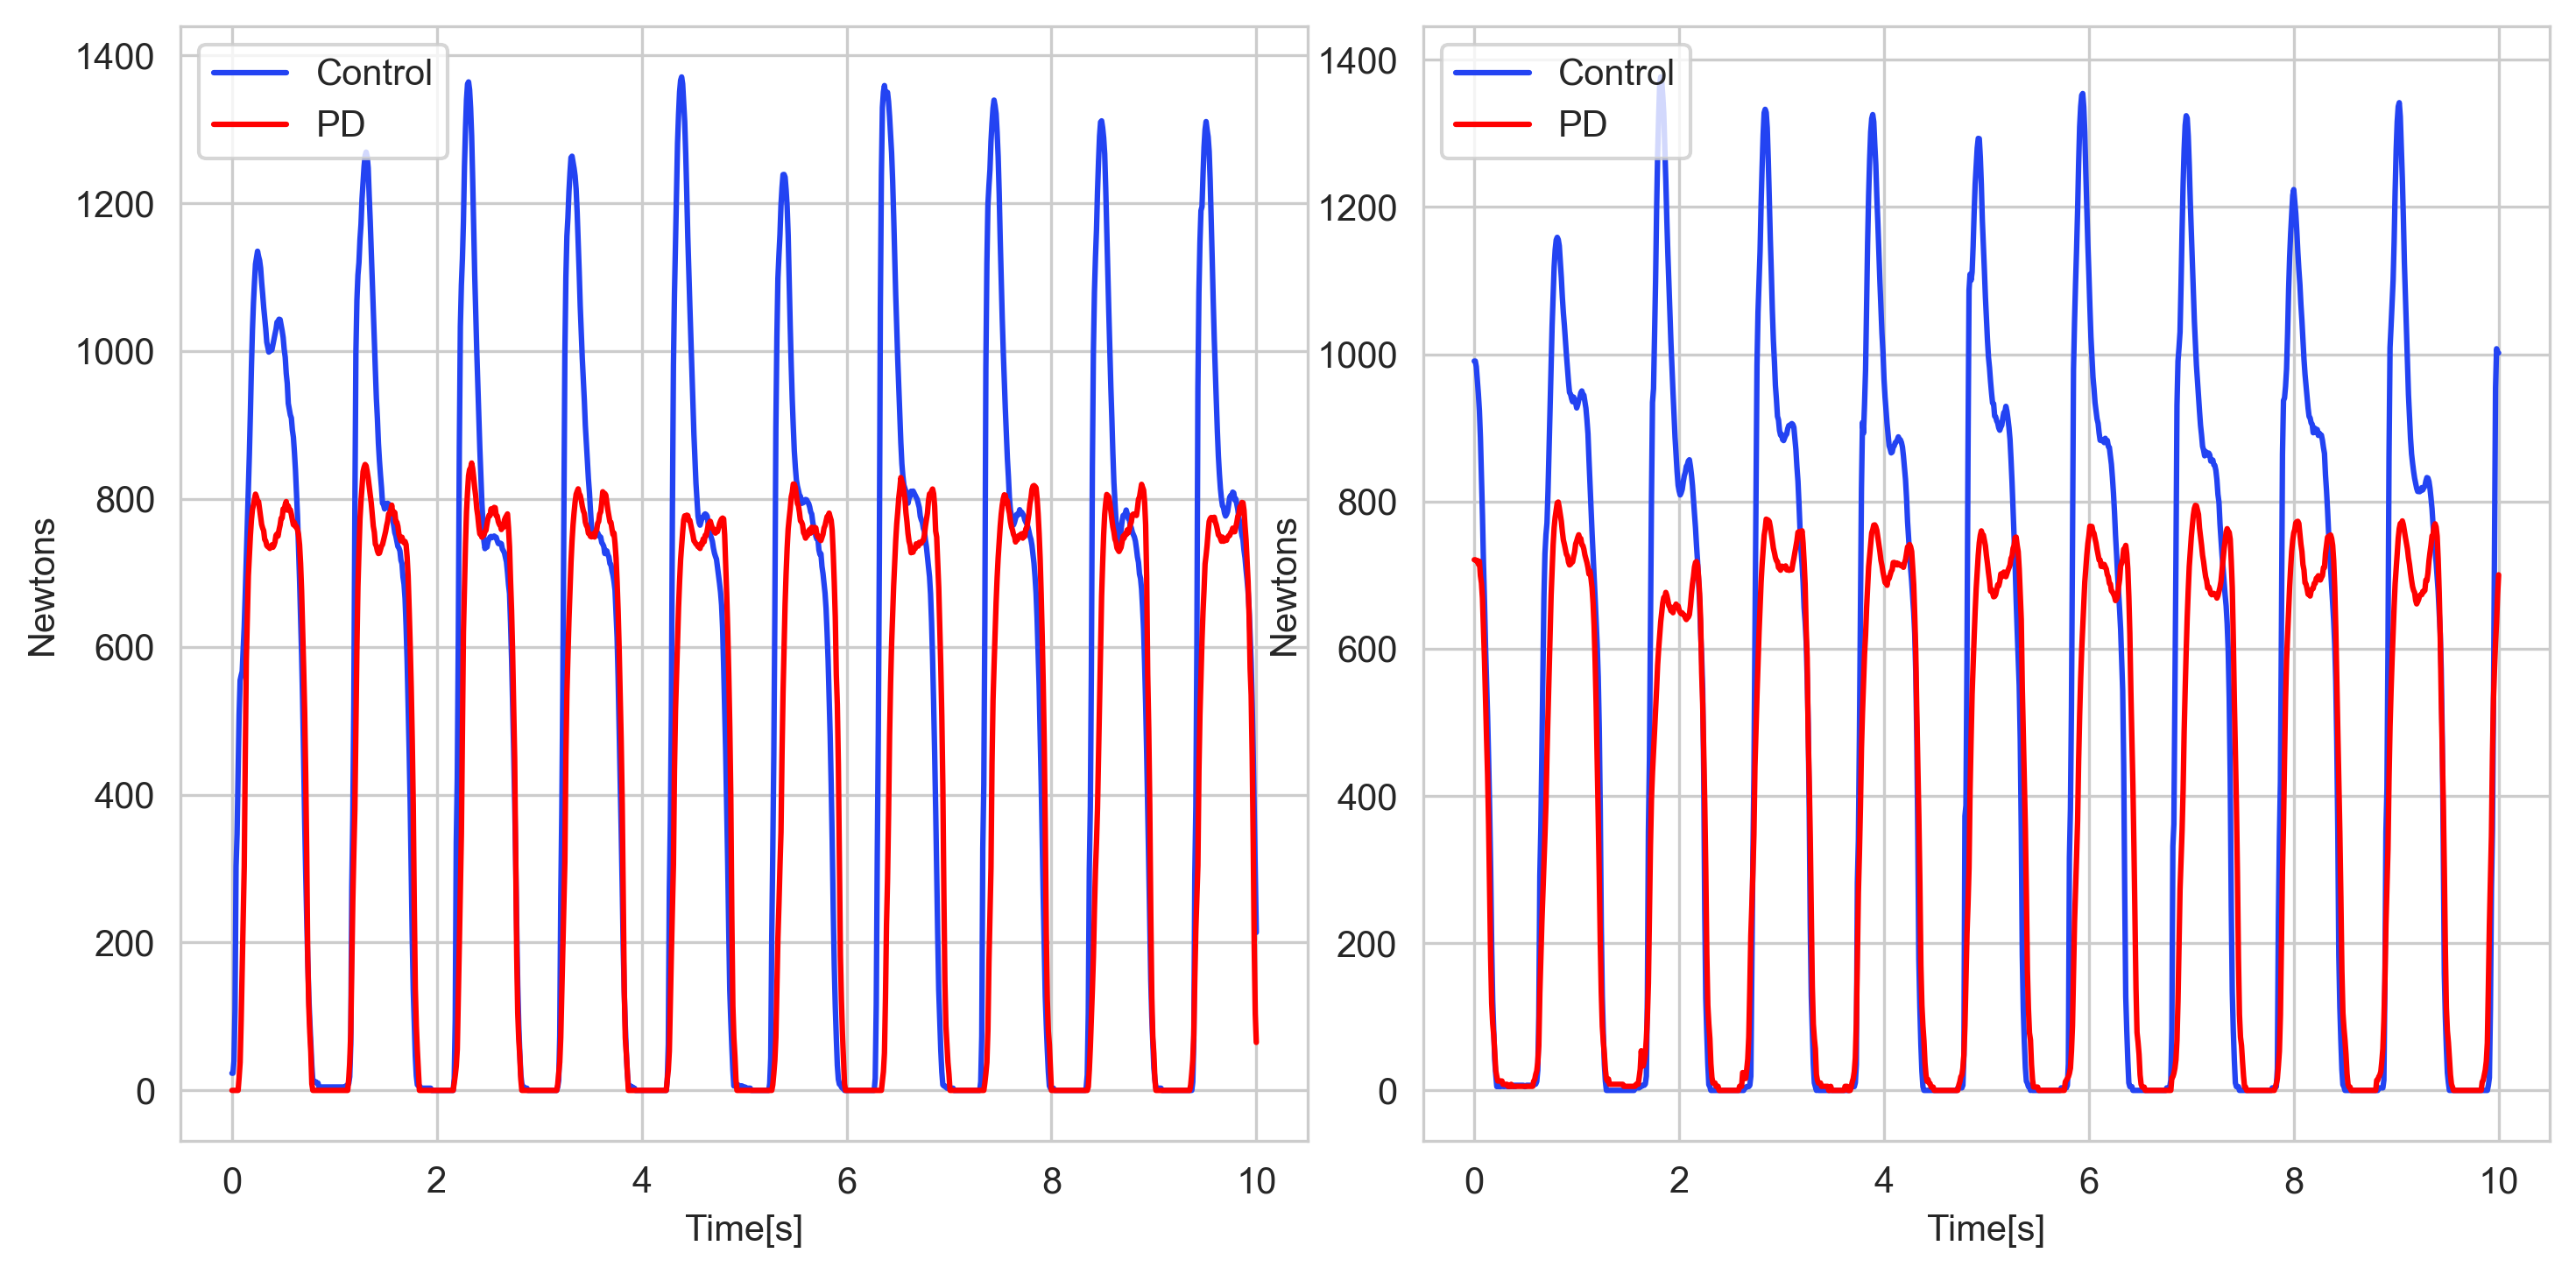

In [67]:
pd_subject = 'GaPt05_01'
control_subject = 'GaCo07_01'

pd_df = pd.read_csv('CSV/' + pd_subject + '.csv').head(1001)
control_df = pd.read_csv('CSV/' + control_subject + '.csv').head(1001)

nrows = 1
ncols = 2

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

for i, fname in enumerate(['Total_Force_Left', 'Total_Force_Right']):
    plt.subplot(nrows, ncols, i + 1)
    plt.tight_layout()
    plt.plot(control_df.Time, control_df[fname], '#2343f2')
    plt.plot(pd_df.Time, pd_df[fname], 'r')
    plt.xlabel('Time[s]')
    plt.ylabel('Newtons')
    plt.legend(["Control", "PD", ], loc='upper left')

plt.show()

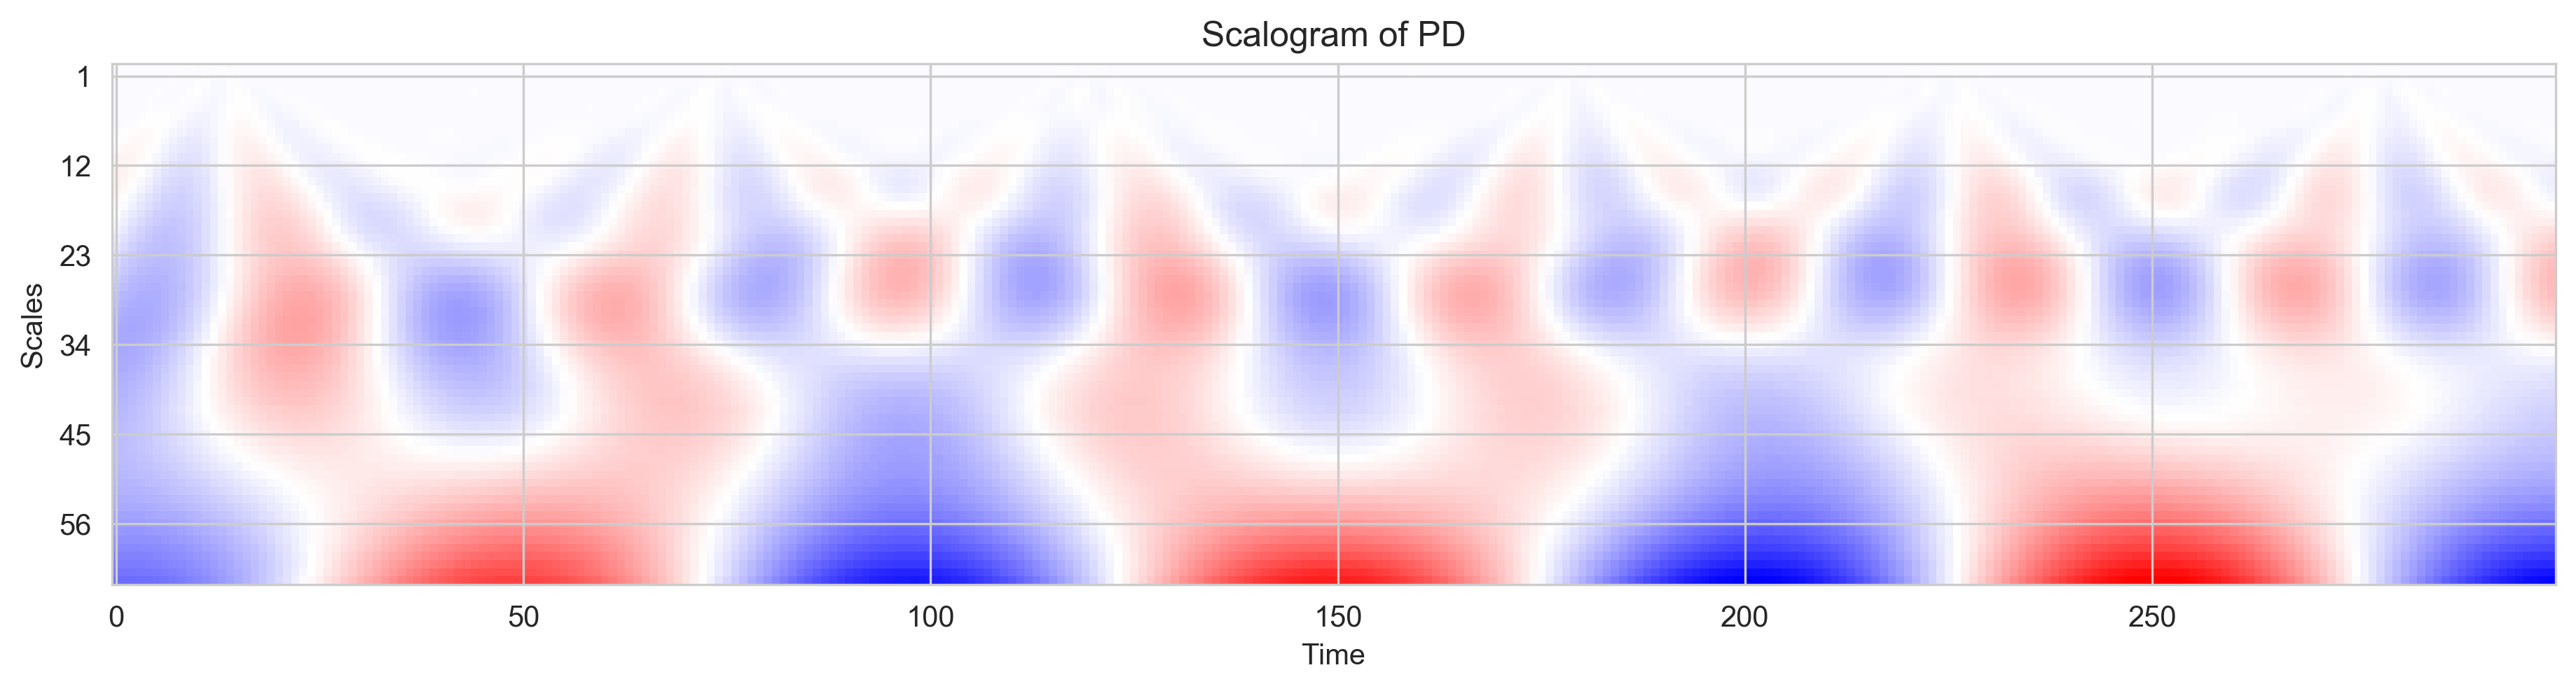

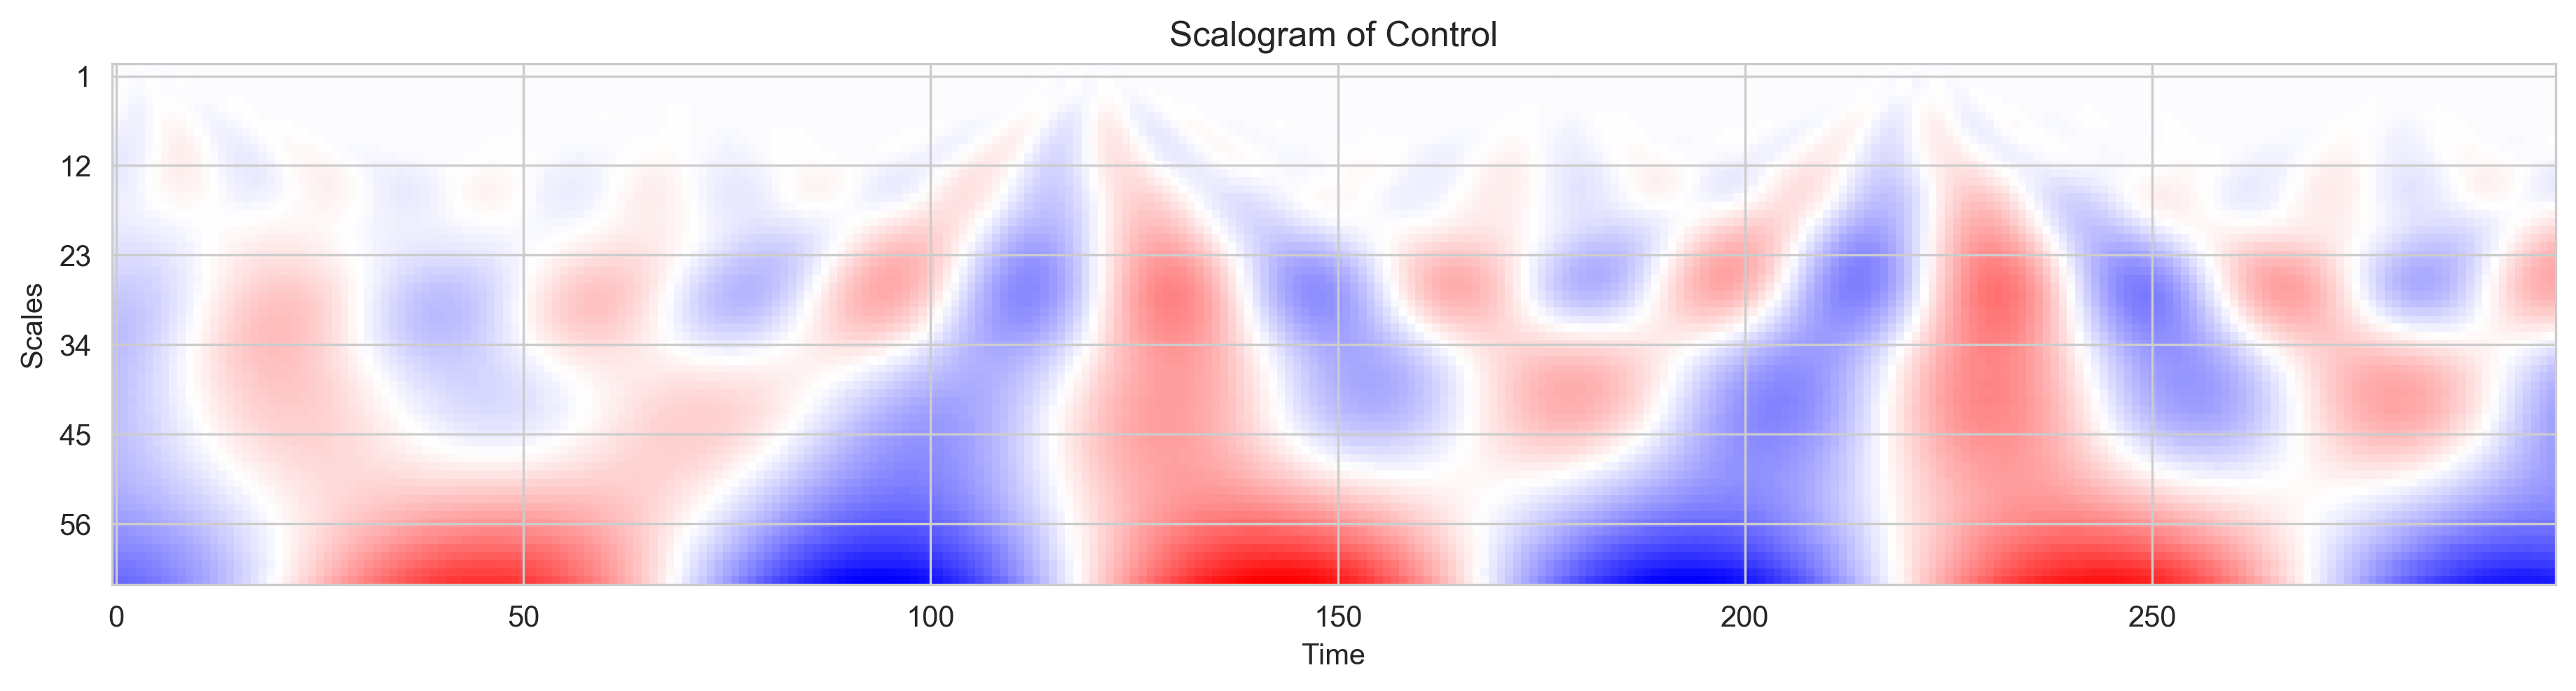

In [68]:
pd_df = pd.read_csv('CSV/' + "GaPt05_01" + '.csv').head(4000)
control_df = pd.read_csv('CSV/' + "GaCo07_01" + '.csv').head(4000)
wavelet = 'morl'
sr = 100 
widths = np.arange(1, 65)
dt = 1 / sr

frequencies = pywt.scale2frequency(wavelet, widths) / dt  # Get frequencies corresponding to scales

wavelet_coeffs, freqs = pywt.cwt(pd_df["Total_Force_Left"], widths, wavelet=wavelet, sampling_period=dt)

# Display the scalogram. We will display a small part of scalogram because the length of scalogram is too big.
plt.imshow(wavelet_coeffs[:, :300], cmap='bwr')
plt.xlabel("Time")
plt.ylabel("Scales")
plt.yticks(widths[0::11])
plt.title("Scalogram of PD")
plt.show()

wavelet_coeffs, freqs = pywt.cwt(control_df["Total_Force_Left"], widths, wavelet=wavelet, sampling_period=dt)

# Display the scalogram. We will display a small part of scalogram because the length of scalogram is too big.
plt.imshow(wavelet_coeffs[:, :300], cmap='bwr')
plt.xlabel("Time")
plt.ylabel("Scales")
plt.yticks(widths[0::11])
plt.title("Scalogram of Control")
plt.show()

In [69]:
# nrows = 2
# ncols = 4
# subjects = ['GaCo03_01', 'GaPt06_01', 'GaPt04_01', 'GaPt03_01']
# category = ['Healthy Control', 'PD Severity 2', 'PD Severity 2.5', 'PD Severity 3']
# colors = ['blue', '#FFD600', 'orange', 'red']
# fig = plt.gcf()
# fig.set_size_inches(ncols * 4, nrows * 4)
# 
# i = 0
# for sub in subjects:
#   df = pd.read_csv('CSV/' + sub + '.csv').head(1001)
#   i += 1
#   for j, fname in enumerate(['Total_Force_Left', 'Total_Force_Right']):
#     plt.subplot(nrows, ncols, i + (j*4))
#     plt.tight_layout()
#     plt.plot(df.Time, df[fname], color=colors[i-1])
#     plt.xlabel('Time (in seconds)')
#     plt.ylabel(fname)
#     plt.title(category[i-1])
#     
# plt.show()

## Preprocess the dataset

In [70]:
X = list()
y = list()
ids = list()
sr = 100
widths = np.arange(1, 65)
dt = 1 / sr
entry_size = 500
for name in tqdm(os.listdir('CSV')):
    if "Pt" in name:
        label = 1
    else:
        label = 0
    signal = pd.read_csv('CSV/' + name)["Total_Force_Left"]
    wavelet_coeffs, _ = pywt.cwt(signal, widths, wavelet=wavelet, sampling_period=dt)
    start = 0
    while start + entry_size <= wavelet_coeffs.shape[1] - 1:
        X.append(wavelet_coeffs[:, start:start + entry_size])
        y.append(label)
        start += entry_size

X = np.array(X)
X = X.transpose(0,2,1)

y = np.array(y)
y = to_categorical(y)

  0%|          | 0/306 [00:00<?, ?it/s]

In [71]:
print(X.shape)
print(y.shape)

(6535, 500, 64)
(6535, 2)


In [72]:
X_train_validation, X_test, y_train_validation, y_test =train_test_split(X, y, test_size=0.15, random_state=12)
print(X_train_validation.shape, X_test.shape, y_train_validation.shape, y_test.shape)
np.savez_compressed(os.getcwd()+"/wave_features_training", a=X_train_validation, b=y_train_validation)
np.savez_compressed(os.getcwd()+"/wave_features_testing", a=X_test, b=y_test)

(5554, 500, 64) (981, 500, 64) (5554, 2) (981, 2)


## Creating Model

In [89]:
def create_model(row, col) :

    n_filters = 32
    filter_width = 3
    dilation_rates = [2**i for i in range(6)] * 2

    history_seq = Input(shape=(row, col))
    x = history_seq

    for dilation_rate in dilation_rates:
        x = Conv1D(filters=n_filters,
                    kernel_size=filter_width, 
                    padding='causal',
                    dilation_rate=dilation_rate, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    out = Conv1D(16, 2, padding='same', kernel_initializer= 'random_normal', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(x)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = GlobalMaxPool1D()(out)

    out = Dense(2, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(out)
    out = Activation('softmax')(out)

    model = Model(history_seq, out)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=["accuracy"])

    return model

ACCURACY_THRESHOLD = 0.97

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('accuracy') > ACCURACY_THRESHOLD:
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

callbacks = myCallback()

model = create_model(500, 64)
print(model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 500, 64)]         0         
                                                                 
 conv1d_66 (Conv1D)          (None, 500, 32)           6176      
                                                                 
 batch_normalization_65 (Ba  (None, 500, 32)           128       
 tchNormalization)                                               
                                                                 
 activation_70 (Activation)  (None, 500, 32)           0         
                                                                 
 conv1d_67 (Conv1D)          (None, 500, 32)           3104      
                                                                 
 batch_normalization_66 (Ba  (None, 500, 32)           128       
 tchNormalization)                                         

### Train the model

In [90]:
training_data = np.load(os.getcwd()+"/wave_features_training.npz")

X = training_data['a']
y = training_data['b']

mean = X.mean()
std = X.std()
X = (X-mean)/ std

print("Mean ", mean, " STD ", std, X.mean(), X.std())

X = X.astype(np.float16)
y = y.astype(np.uint8)

print("Input shapes ", X.shape, y.shape)

f = open(os.getcwd()+'/wave_mean_std.pkl', 'wb')
pickle.dump([mean, std, y], f)
f.close()

r,c = X[0].shape

# X1, Xval, y1, yval = train_test_split(X, y, test_size=0.20, random_state=42)#, random_state=int(time.time()))

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=12)

count = 1

for train, test in kfold.split(X, np.argmax(y, axis= -1)):
    print("K Fold Step  ", count)
    model.fit(X[train], y[train], validation_data= (X[test], y[test]), batch_size= 128, epochs= 30, verbose= 1, callbacks=[callbacks])
    # model.save(os.getcwd()+"/pd_wave_classifier.keras")
    count += 1
    
model.save(os.getcwd()+"/pd_wave_classifier.keras")

Mean  0.5909312930383159  STD  680.7696226922592 -1.6887223824330792e-18 0.9999999999999987
Input shapes  (5554, 500, 64) (5554, 2)
K Fold Step   1
Epoch 1/30
29/29 [==============================] - 12s 357ms/step - loss: 1.0331 - accuracy: 0.6707 - val_loss: 1.0912 - val_accuracy: 0.6928
Epoch 2/30
29/29 [==============================] - 10s 359ms/step - loss: 0.9079 - accuracy: 0.7485 - val_loss: 1.0923 - val_accuracy: 0.5562
Epoch 3/30
29/29 [==============================] - 11s 385ms/step - loss: 0.8322 - accuracy: 0.7947 - val_loss: 1.0923 - val_accuracy: 0.5027
Epoch 4/30
29/29 [==============================] - 12s 431ms/step - loss: 0.7577 - accuracy: 0.8339 - val_loss: 1.0879 - val_accuracy: 0.5470
Epoch 5/30
29/29 [==============================] - 12s 428ms/step - loss: 0.7136 - accuracy: 0.8652 - val_loss: 1.0476 - val_accuracy: 0.6598
Epoch 6/30
29/29 [==============================] - 10s 338ms/step - loss: 0.6455 - accuracy: 0.9014 - val_loss: 0.9991 - val_accuracy: 0

### Evaluation of Model

In [105]:
model = load_model(os.getcwd()+"/pd_wave_classifier.keras", compile= False)

print(model.summary())

f = open(os.getcwd()+'/wave_mean_std.pkl', 'rb')
mean, std, poss_knnn = pickle.load(f)
f.close()

testing_data = np.load(os.getcwd()+"/wave_features_testing.npz")
X_test = testing_data['a']
y_test = testing_data['b']

X_test = X_test.astype(np.float16)

X_test = (X_test-mean)/ std
print("Mean ", mean, " STD ", std, X_test.mean(), X_test.std())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 500, 64)]         0         
                                                                 
 conv1d_66 (Conv1D)          (None, 500, 32)           6176      
                                                                 
 batch_normalization_65 (Ba  (None, 500, 32)           128       
 tchNormalization)                                               
                                                                 
 activation_70 (Activation)  (None, 500, 32)           0         
                                                                 
 conv1d_67 (Conv1D)          (None, 500, 32)           3104      
                                                                 
 batch_normalization_66 (Ba  (None, 500, 32)           128       
 tchNormalization)                                         

/Users/mihajlogumenuk/miniconda3/envs/SP/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [106]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=-1)
ypred = ypred.flatten()
print(ypred)

31/31 [==============================] - 2s 30ms/step
[1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1
 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1
 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1

In [107]:
y_test = np.argmax(y_test, axis=-1)
y_test = y_test.flatten()
print(y_test)

[1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0
 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1
 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1
 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1
 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1
 1 1 1 1 1 1 0 0 1 1 1 1 

In [108]:
print(classification_report(y_test, ypred, target_names=["healthy", "unhealthy"]))

              precision    recall  f1-score   support

     healthy       0.93      0.85      0.89       298
   unhealthy       0.94      0.97      0.95       683

    accuracy                           0.94       981
   macro avg       0.94      0.91      0.92       981
weighted avg       0.94      0.94      0.93       981


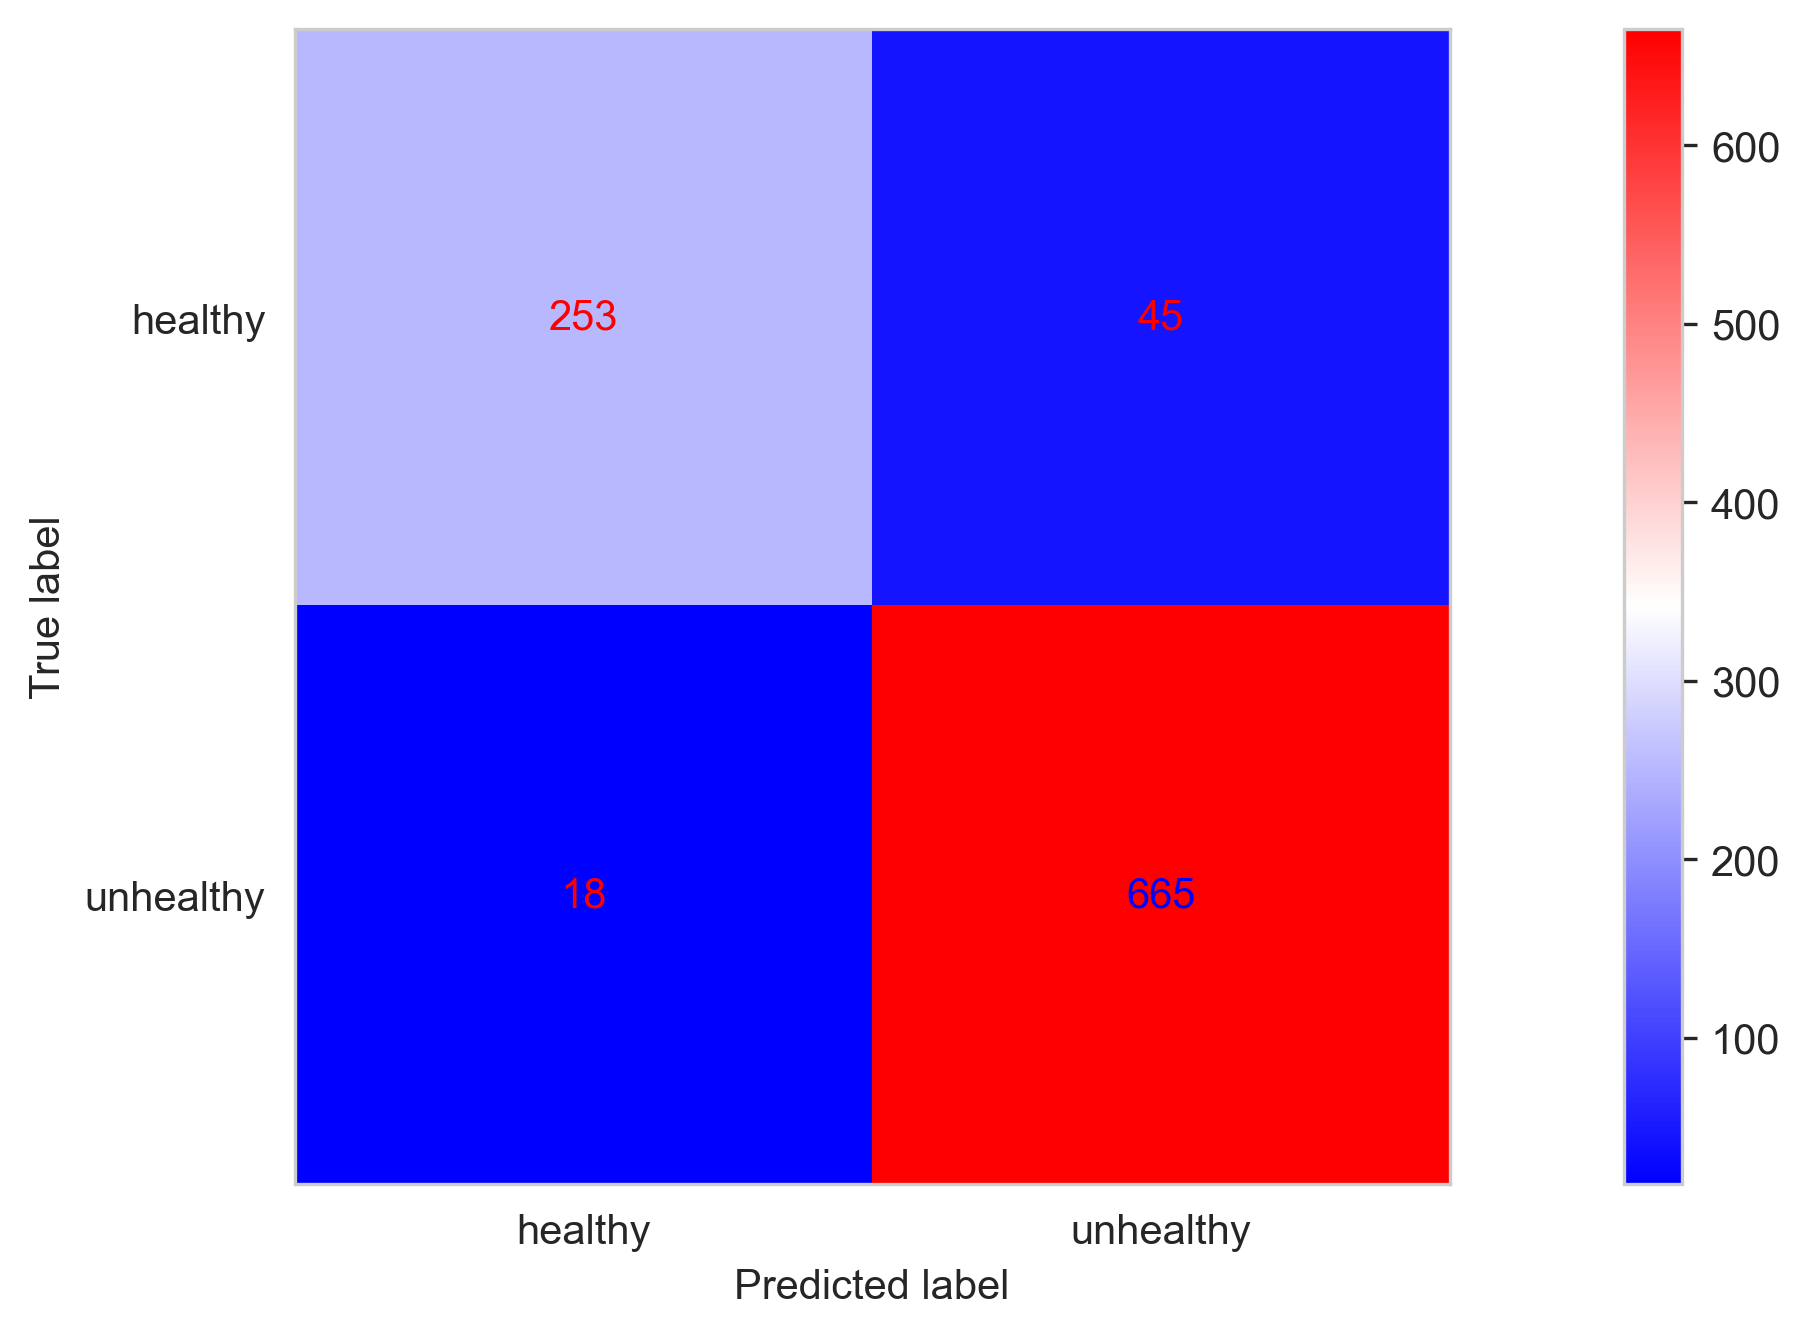

In [114]:
confusion_mat = confusion_matrix(y_test, ypred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = ["healthy", "unhealthy"])

cm_display.plot(cmap="bwr")
plt.grid(alpha=0)
plt.show()
